In [1]:
import numpy as np
from test import test_index
from sklearn.model_selection import train_test_split


Get the dataset

In [2]:
all_data = np.loadtxt('./sample_data/final128_10K.txt')
(data_matrix, query_matrix) = train_test_split(all_data, test_size = 0.1)
len(data_matrix), len(query_matrix)

(9000, 1000)

In [3]:
data_matrix[0].shape

(128,)

<hr>

## Params

In [5]:
regularity = 16
candidates = 100
guard_hops = 25
attempts = 1
k = 100 # top k neigbours

In [6]:
from product_quantization import PQ
pq = PQ(n_subvectors=8, n_bits_per_vector=5)

In [10]:
params = {'n_subvectors': 8, 'n_bits': 8, 'lookup':False, 'save':True}
test_index('PQ',  data=data_matrix, query=query_matrix, k=10, params=params)

{'method': 'PQ',
 'construction-time': 5.585,
 'construction-memory': 141.33,
 'search-time': 0.637,
 'search-memory': 1323.01,
 'recall': 0.76}

<hr>

In [5]:
params = {'M': regularity, 'efConstruction': candidates, 'post' : 2}
test_index('hnsw', data=data_matrix, query=query_matrix, k=k, params=params)

{'method': 'hnsw',
 'construction-time': 0.993,
 'construction-memory': 24.15,
 'search-time': 0.02,
 'search-memory': 208.9,
 'recall': 0.81}

In [6]:
params = {'NN': regularity, 'efConstruction': candidates}
test_index('sw-graph', data=data_matrix, query=query_matrix, k=k, params=params)

{'method': 'sw-graph',
 'construction-time': 0.717,
 'construction-memory': 2.21,
 'search-time': 0.041,
 'search-memory': 1744.9,
 'recall': 0.83}

In [7]:
params = {'regularity':regularity, 'attempts':attempts, 'guard_hops':guard_hops}
test_index('NSWG', data=data_matrix, query=query_matrix, k=k, params=params)

{'method': 'NSWG',
 'construction-time': 4.608,
 'construction-memory': 25.29,
 'search-time': 0.742,
 'search-memory': 905.22,
 'recall': 0.88}

In [8]:
params = {'leaf_size' : 2}
test_index('kd-tree', data=data_matrix, query=query_matrix, k=k, params=params)

{'method': 'kd-tree',
 'construction-time': 0.148,
 'construction-memory': 16.94,
 'search-time': 18.794,
 'search-memory': 843.78,
 'recall': 1.0}

In [9]:
params = {'leaf_size' : 2}
test_index('ball-tree', data=data_matrix, query=query_matrix, k=k, params=params)

{'method': 'ball-tree',
 'construction-time': 0.132,
 'construction-memory': 8.46,
 'search-time': 3.721,
 'search-memory': 36.86,
 'recall': 1.0}

In [10]:
params = {'n_subvectors': 8, 'n_bits': 8}
test_index('PQ',  data=data_matrix, query=query_matrix, k=k, params=params)

## Regularities comparison

In [11]:
regularities = [2, 4, 8, 16, 32, 64, 128, 256]

In [73]:
from collections import defaultdict
methods = [('hnsw', {'M': None, 'post' : 2}), 
           ('sw-graph', {'NN': None}),
           ('NSWG', {'regularity': None, 'guard_hops':25})
            ]
searching = defaultdict(list)
construction = defaultdict(list)
recalls = defaultdict(list)
construction_memory = defaultdict(list)
search_memory = defaultdict(list)
for reg in regularities:
    for method, params in methods:
        params[list(params.keys())[0]] = reg
        result = test_index(method, data=data_matrix, query=query_matrix, k=k, params=params)
        construction[method].append(result['construction-time'])
        searching[method].append(result['search-time'])
        recalls[method].append(result['recall'])
        construction_memory[method].append(result['construction-memory'])
        search_memory[method].append(result['search-memory'])


In [74]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.rcParams["figure.figsize"] = (12, 25)

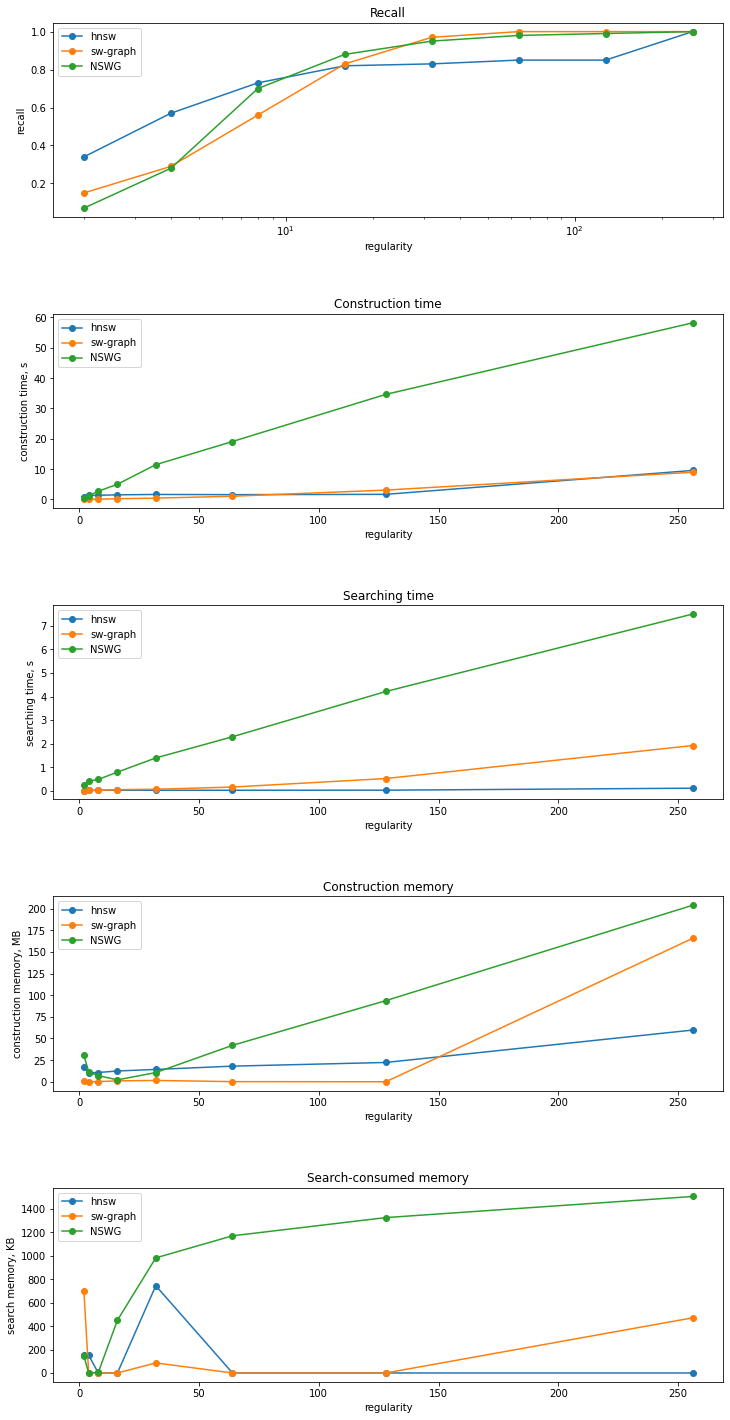

In [75]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
ax1.set(xlabel='regularity', ylabel='recall')
ax1.set_xscale('log')
for val in recalls.values():
    ax1.plot(regularities, val, marker="o")
ax1.legend(recalls.keys())
ax1.set_title('Recall')


ax2.set_title('Construction time')
ax2.set(xlabel='regularity', ylabel='construction time, s')
# ax2.set_xscale('log')
for val in construction.values():
    ax2.plot(regularities, val, marker="o")
ax2.legend(construction.keys())

ax3.set_title('Searching time')
ax3.set(xlabel='regularity', ylabel='searching time, s')
# ax3.set_xscale('log')
for val in searching.values():
    ax3.plot(regularities, val, marker="o")
ax3.legend(searching.keys())


ax4.set_title('Construction memory')
ax4.set(xlabel='regularity', ylabel='construction memory, MB')
for val in construction_memory.values():
    ax4.plot(regularities, val, marker="o")
ax4.legend(construction_memory.keys())

ax5.set_title('Search-consumed memory')
ax5.set(xlabel='regularity', ylabel='search memory, KB')
for val in search_memory.values():
    ax5.plot(regularities, val, marker="o")
ax5.legend(search_memory.keys())

plt.subplots_adjust(hspace = .5)

plt.show()

### Product Quantization

dependency on \# of centroids <br>
n_subvectors=`8`

In [39]:
import math
n_subvectors = 8
centroids_range = [2, 4, 8, 16, 32, 64, 128, 256, 512, 1024]
for n_centroids in centroids_range:
    params = {'n_subvectors': n_subvectors, 'n_bits': int(math.log2(n_centroids))}
    result = test_index('PQ', data=data_matrix, query=query_matrix, k=k, params=params)
    construction['PQ'].append(result['construction-time'])
    searching['PQ'].append(result['search-time'])
    recalls['PQ'].append(result['recall'])
    construction_memory['PQ'].append(result['construction-memory'])
    search_memory['PQ'].append(result['search-memory'])

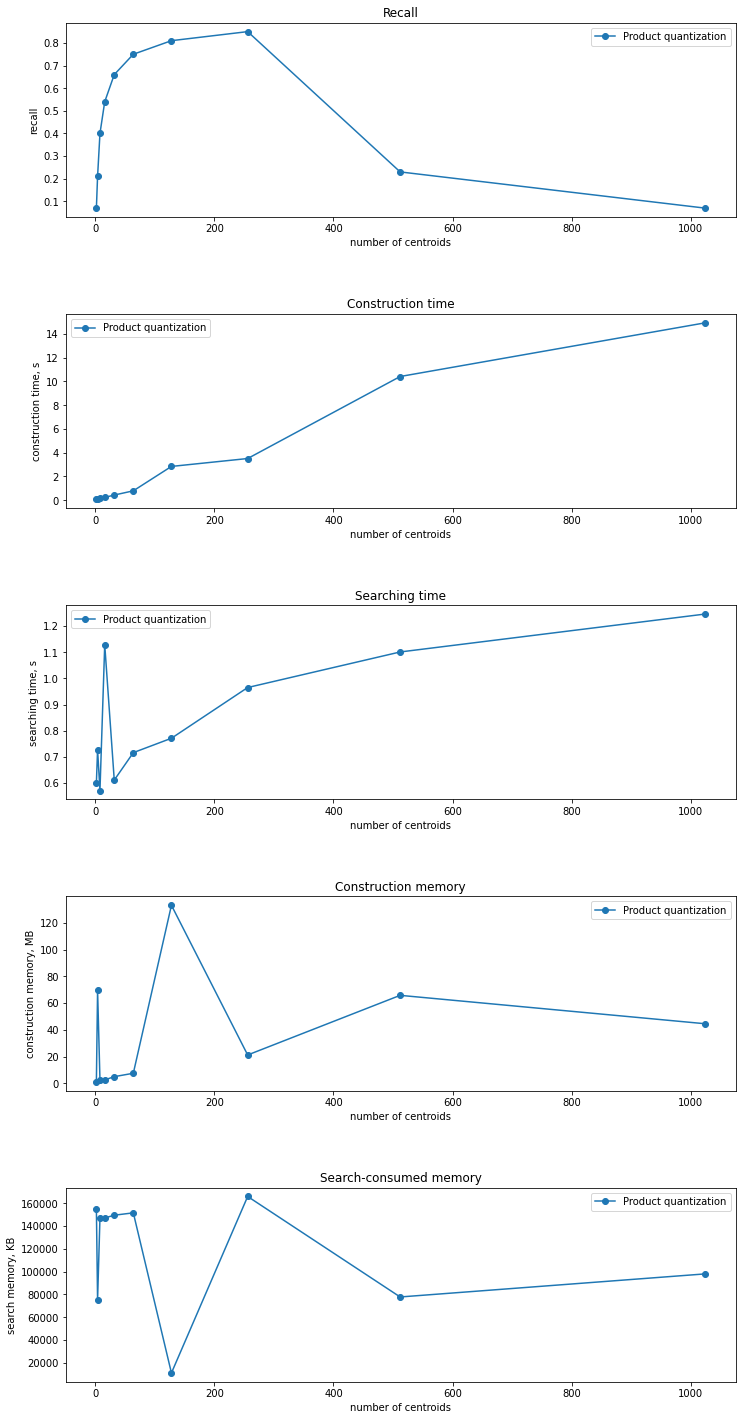

In [42]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
ax1.set(xlabel='number of centroids', ylabel='recall')
# ax1.set_xscale('log')
ax1.plot(centroids_range, recalls['PQ'], marker="o")
ax1.legend(['Product quantization'])
ax1.set_title('Recall')


ax2.set(xlabel='number of centroids', ylabel='construction time, s')
# ax2.set_xscale('log')
ax2.plot(centroids_range, construction['PQ'], marker="o")
ax2.legend(['Product quantization'])
ax2.set_title('Construction time')

ax3.set_title('Searching time')
ax3.set(xlabel='number of centroids', ylabel='searching time, s')
# ax3.set_xscale('log')
ax3.plot(centroids_range, searching['PQ'], marker="o")
ax3.legend(['Product quantization'])


ax4.set_title('Construction memory')
ax4.set(xlabel='number of centroids', ylabel='construction memory, MB')
ax4.plot(centroids_range, construction_memory['PQ'], marker="o")
ax4.legend(['Product quantization'])

ax5.set_title('Search-consumed memory')
ax5.set(xlabel='number of centroids', ylabel='search memory, KB')
ax5.plot(centroids_range, search_memory['PQ'], marker="o")
ax5.legend(['Product quantization'])

plt.subplots_adjust(hspace = .5)

plt.show()

In [54]:
construction['PQ'] = []
recalls['PQ'] = []
searching['PQ']=[]
search_memory['PQ']=[]
construction_memory['PQ']=[]

dependency on \# of subvector. vector length = `128`
\# of centroids = `256`

In [55]:
len(data_matrix[0])

128

In [56]:
n_bits = 8
n_subvectors = 1
n_subvectors_range = []
while n_subvectors <= len(data_matrix[0]):
    params = {'n_subvectors': n_subvectors, 'n_bits': n_bits}
    result = test_index('PQ', data=data_matrix, query=query_matrix, k=k, params=params)
    construction['PQ'].append(result['construction-time'])
    searching['PQ'].append(result['search-time'])
    recalls['PQ'].append(result['recall'])
    construction_memory['PQ'].append(result['construction-memory'])
    search_memory['PQ'].append(result['search-memory'])
    n_subvectors_range.append(n_subvectors)
    n_subvectors *= 2
    print(n_subvectors)

2
4
8
16
32
64
128
256


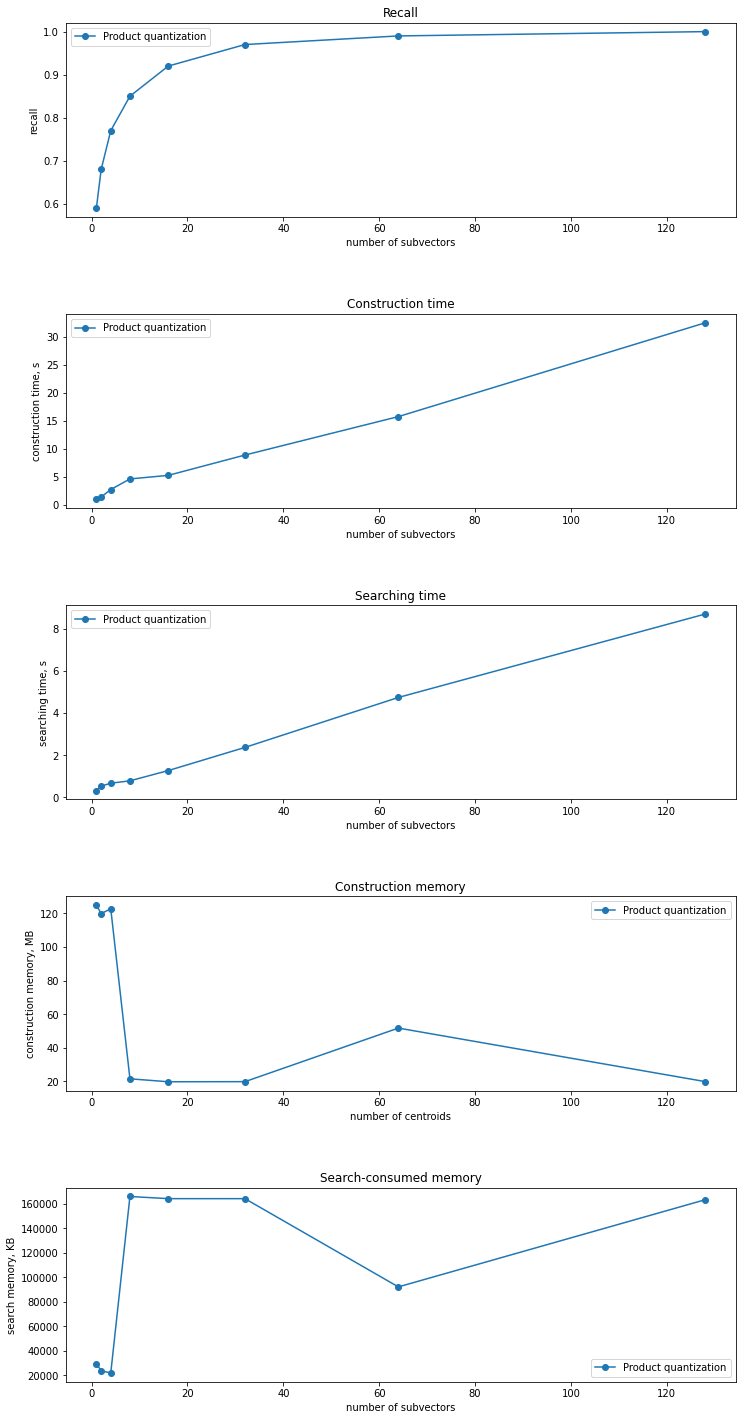

In [59]:
fig, (ax1, ax2, ax3, ax4, ax5) = plt.subplots(5)
ax1.set(xlabel='number of subvectors', ylabel='recall')
# ax1.set_xscale('log')
ax1.plot(n_subvectors_range, recalls['PQ'], marker="o")
ax1.legend(['Product quantization'])
ax1.set_title('Recall')


ax2.set(xlabel='number of subvectors', ylabel='construction time, s')
# ax2.set_xscale('log')
ax2.plot(n_subvectors_range, construction['PQ'], marker="o")
ax2.legend(['Product quantization'])
ax2.set_title('Construction time')

ax3.set_title('Searching time')
ax3.set(xlabel='number of subvectors', ylabel='searching time, s')
# ax3.set_xscale('log')
ax3.plot(n_subvectors_range, searching['PQ'], marker="o")
ax3.legend(['Product quantization'])


ax4.set_title('Construction memory')
ax4.set(xlabel='number of centroids', ylabel='construction memory, MB')
ax4.plot(n_subvectors_range, construction_memory['PQ'], marker="o")
ax4.legend(['Product quantization'])

ax5.set_title('Search-consumed memory')
ax5.set(xlabel='number of subvectors', ylabel='search memory, KB')
ax5.plot(n_subvectors_range, search_memory['PQ'], marker="o")
ax5.legend(['Product quantization'])

plt.subplots_adjust(hspace = .5)

plt.show()

Try n_subvector=`16` and n_centroids=`256` for comparisons with other approaches

In [65]:
params = {'n_subvectors': 16, 'n_bits': 8}
resultPQ = test_index('PQ', data=data_matrix, query=query_matrix, k=k, params=params)
resultPQ

{'method': 'PQ',
 'construction-time': 4.991,
 'construction-memory': 19.71,
 'search-time': 1.116,
 'search-memory': 164110.34,
 'recall': 0.92}

In [86]:
params = {'n_subvectors': 16, 'n_bits': 7} ## 128 centroids
resultPQ2 = test_index('PQ', data=data_matrix, query=query_matrix, k=k, params=params)
resultPQ2
# twice less construction time, but more than twice more memory consumption

{'method': 'PQ',
 'construction-time': 2.522,
 'construction-memory': 66.15,
 'search-time': 1.115,
 'search-memory': 82567.17,
 'recall': 0.89}

In [76]:
recalls

defaultdict(list,
            {'hnsw': [0.34, 0.57, 0.73, 0.82, 0.83, 0.85, 0.85, 1.0],
             'sw-graph': [0.15, 0.29, 0.56, 0.83, 0.97, 1.0, 1.0, 1.0],
             'NSWG': [0.07, 0.28, 0.7, 0.88, 0.95, 0.98, 0.99, 1.0]})

###  With approximately the same recall from other methods

#### HNSW

In [81]:
print('Recall:', recalls['hnsw'][-5])
print('Construction time:', construction['hnsw'][-5])
print('Search time:', searching['hnsw'][-5])
print('Construction memory, MB:', construction_memory['hnsw'][-5])
print('Search memory, KB:', search_memory['hnsw'][-5])

Recall: 0.82
Construction time: 1.523
Search time: 0.022
Construction memory, MB: 12.46
Search memory, KB: 0.0


#### SW-graph

In [83]:
print('Recall:', recalls['sw-graph'][-4])
print('Construction time:', construction['sw-graph'][-4])
print('Search time:', searching['sw-graph'][-4])
print('Construction memory, MB:', construction_memory['sw-graph'][-4])
print('Search memory, KB:', search_memory['sw-graph'][-4])

Recall: 0.97
Construction time: 0.432
Search time: 0.067
Construction memory, MB: 1.53
Search memory, KB: 86.02


#### NSWG

In [84]:
print('Recall:', recalls['NSWG'][-5])
print('Construction time:', construction['NSWG'][-5])
print('Search time:', searching['NSWG'][-5])
print('Construction memory, MB:', construction_memory['NSWG'][-5])
print('Search memory, KB:', search_memory['NSWG'][-5])

Recall: 0.88
Construction time: 5.021
Search time: 0.794
Construction memory, MB: 2.18
Search memory, KB: 450.56


#### Product quantization (naive list distance storing)

In [88]:
params = {'n_subvectors': 16, 'n_bits': 8} ## 256 centroids
resultPQ2 = test_index('PQ', data=data_matrix, query=query_matrix, k=k, params=params)
print('Recall:', resultPQ2['recall'])
print('Construction time:', resultPQ2['construction-time'])
print('Search time:', resultPQ2['search-time'])
print('Construction memory, MB:', resultPQ2['construction-memory'])
print('Search memory, KB:', resultPQ2['search-memory'])

Recall: 0.92
Construction time: 4.898
Search time: 1.057
Construction memory, MB: 19.54
Search memory, KB: 164151.3
